In [7]:
import os

# Zeige das aktuelle Arbeitsverzeichnis an
print("Aktuelles Verzeichnis:", os.getcwd())

aktuelles_verzeichnis = os.getcwd()


Aktuelles Verzeichnis: C:\Users\adam8\OneDrive\programmieren\coding\python\Statistik\testat2


In [8]:
os.chdir(aktuelles_verzeichnis)

In [27]:
import pandas as pd
from chardet.universaldetector import UniversalDetector

# Bestimmen Sie das Encoding automatisch
detector = UniversalDetector()
with open("sr_aufg_2_54 (1).txt", 'rb') as file:
    for line in file:
        detector.feed(line)
        if detector.done:
            break
    detector.close()

# Zeige das ermittelte Encoding
print(f"Erkanntes Encoding: {detector.result['encoding']}")


Erkanntes Encoding: ascii


In [28]:
import pandas as pd

df = pd.read_csv(
    'sr_aufg_2_54 (1).txt',    # Pfad zur Datei
    sep=r'\s+',                # Trenner: ein oder mehrere Whitespace-Zeichen
    encoding=detector.result['encoding'],
    header=None,               # keine Kopfzeile in der Datei
    names=['Jahr', 'Bevölkerung']  # Spaltennamen vergeben
)


In [29]:
print(df.head())      # zeigt die ersten 5 Zeilen
print(df.info() )     # zeigt Datentypen und vermisst keine Werte?
#df.describe()  # gibt dir erste Statistik-Kennzahlen


   Jahr Bevölkerung
0  1790    3,929214
1  1800    5,308483
2  1810    7,239881
3  1820    9,638453
4  1830   12,866020
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Jahr         23 non-null     int64 
 1   Bevölkerung  23 non-null     object
dtypes: int64(1), object(1)
memory usage: 500.0+ bytes
None


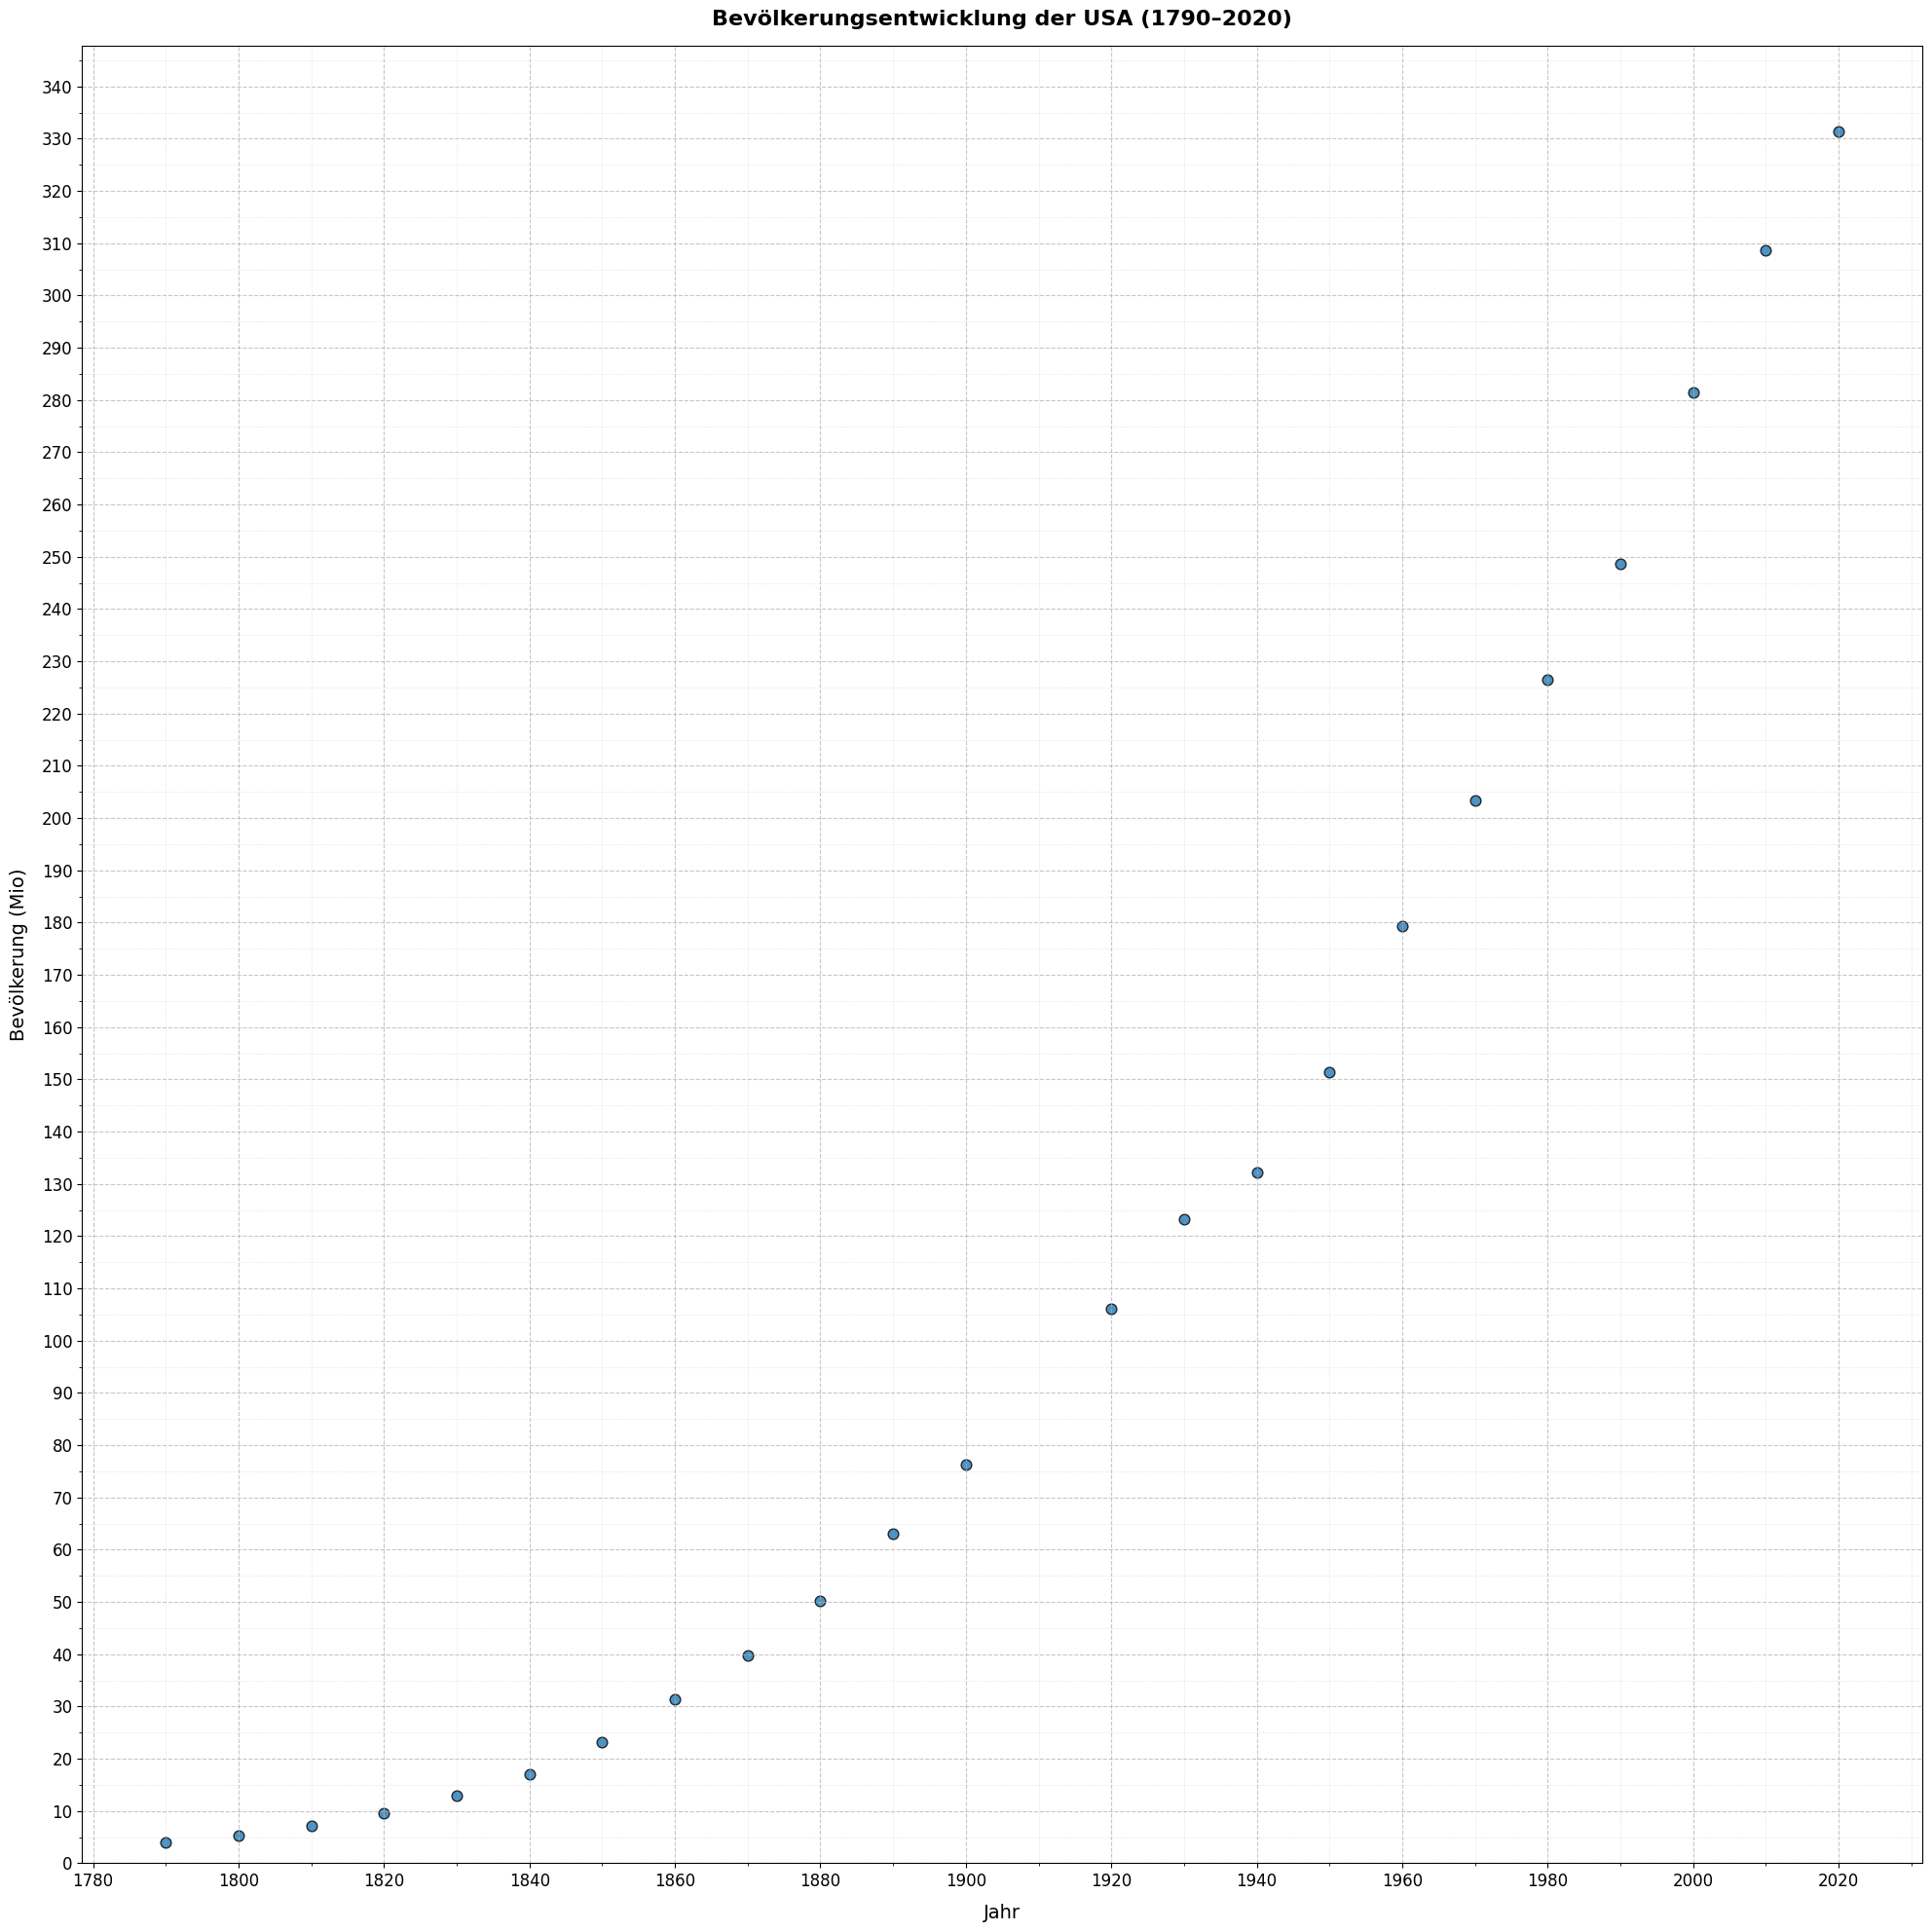

In [41]:
# Endgültiges Streudiagramm im Jupyter Notebook

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Annahme: 'df' existiert bereits mit 'Jahr' und 'Bevölkerung' (als Strings mit Komma)

# 1. Bevölkerung in float umwandeln: Komma → Punkt
df['Bevölkerung'] = (
    df['Bevölkerung']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# 2. Plot erstellen
fig, ax = plt.subplots(figsize=(20, 20))

# 3. Scatter zeichnen
ax.scatter(
    df['Jahr'],
    df['Bevölkerung'],
    marker='o',
    s=60,
    alpha=0.8,
    edgecolor='black'
)

# 4. Achsenbereich festlegen (Y-Achse beginnt bei 0)
ax.set_ylim(bottom=0)

# 5. Ticks setzen
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))  # Hauptticks alle 20 Jahre
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))  # Nebenticks alle 10 Jahre
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))  # Hauptticks alle 10 Mio.
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))   # Nebenticks alle 5 Mio.

# 6. Raster hinzufügen
ax.grid(which='major', linestyle='--', linewidth=0.8, alpha=0.7)
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# 7. Titel und Beschriftungen
ax.set_title('Bevölkerungsentwicklung der USA (1790–2020)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Jahr', fontsize=14, labelpad=10)
ax.set_ylabel('Bevölkerung (Mio)', fontsize=14, labelpad=10)

# 8. Layout optimieren und anzeigen
plt.tight_layout()
plt.show()
